In [1]:
!pip install Qiskit ipywidgets
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit-optimization
!pip install cplex
!pip install ibm-quantum-widgets
!pip install docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 4.1 MB/s 
     |████████████████████████████████| 18.0 MB 20.7 MB/s 
     |████████████████████████████████| 240 kB 75.6 MB/s 
     |████████████████████████████████| 198 kB 75.7 MB/s 
     |████████████████████████████████| 54 kB 703 kB/s 
     |████████████████████████████████| 112 kB 70.9 MB/s 
     |████████████████████████████████| 1.6 MB 66.1 MB/s 
     |████████████████████████████████| 943 kB 61.7 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 38.1 MB 100.6 MB/s 
     |████████████████████████████████| 4.0 MB 50.4 MB/s 
     |████████████████████████████████| 112 kB 74.8 MB/s 
  Created wheel for Qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=4ffe6e8

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [3]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils.algorithm_globals import algorithm_globals
algorithm_globals.massive=True

# If CPLEX is installed, you can uncomment this line to import the CplexOptimizer.
# CPLEX can be used in this tutorial to solve the convex continuous problem,
# but also as a reference to solve the QUBO, or even the full problem.
#
# from qiskit.optimization.algorithms import CplexOptimizer

In [4]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

In [5]:
# construct model using docplex
mdl = Model("ex7")

#3 servers and 5 virtual machines
#all servers have the same idle and dynamic power consumption
#all servers have the same maximum cpu capacity

s0 = mdl.binary_var(name="s0")
s1 = mdl.binary_var(name="s1")
s2 = mdl.binary_var(name="s2")

v00 = mdl.binary_var(name="v00")
v10 = mdl.binary_var(name="v10")
v20 = mdl.binary_var(name="v20")
v30 = mdl.binary_var(name="v30")
v40 = mdl.binary_var(name="v40")
v01 = mdl.binary_var(name="v01")
v11 = mdl.binary_var(name="v11")
v21 = mdl.binary_var(name="v21")
v31 = mdl.binary_var(name="v31")
v41 = mdl.binary_var(name="v41")
v02 = mdl.binary_var(name="v02")
v12 = mdl.binary_var(name="v12")
v22 = mdl.binary_var(name="v22")
v32 = mdl.binary_var(name="v32")
v42 = mdl.binary_var(name="v42")

#pi = mdl.continuous_var(name="pi")
#pd = mdl.continuous_var(name="pd")
#pi = mdl.binary_var(name="pi")
#pd = mdl.binary_var(name="pd")
pi = 10
pd = 5

c0 = c1 = c2 = 100
c3 = c4 = c5 = 100
c6 = c7 = c8 = c9 = 100
c10 = c11 = c12 = c13 = c14 = 100
c0 = 100


u00 = mdl.binary_var(name="u00")
u10 = mdl.binary_var(name="u10")
u20 = mdl.binary_var(name="u20")
u30 = mdl.binary_var(name="u30")
u40 = mdl.binary_var(name="u40")
u01 = mdl.binary_var(name="u01")
u11 = mdl.binary_var(name="u11")
u21 = mdl.binary_var(name="u21")
u31 = mdl.binary_var(name="u31")
u41 = mdl.binary_var(name="u41")
u02 = mdl.binary_var(name="u02")
u12 = mdl.binary_var(name="u12")
u22 = mdl.binary_var(name="u22")
u32 = mdl.binary_var(name="u32")
u42 = mdl.binary_var(name="u42")

In [6]:
sum0 = (u00*v00+u10*v10+u20*v20+u30*v30+u40*v40)
sum1 = (u01*v01+u11*v11+u21*v21+u31*v31+u41*v41)
sum2 = (u02*v02+u12*v12+u22*v22+u32*v32+u42*v42)
sum3 = (v00+v10+v20+v30+v40+v01+v11+v21+v31+v41+v02+v12+v22+v32+v42)

In [7]:
mdl.maximize((pi*s0+pd*(sum0))+(pi*s1+pd*(sum1))+(pi*s2+pd*(sum2)))
mdl.add_constraint(sum0 <= c0*s0, "cons0")
mdl.add_constraint(sum1 <= c5*s1, "cons1")
mdl.add_constraint(sum2 <= c10*s2, "cons2")
mdl.add_constraint(sum3 == 1, "consv")
mdl.add_constraint(u00 <= c0, "consu0")
mdl.add_constraint(u10 <= c1, "consu1")
mdl.add_constraint(u20 <= c2, "consu2")
mdl.add_constraint(u30 <= c3, "consu3")
mdl.add_constraint(u40 <= c4, "consu4")
mdl.add_constraint(u01 <= c5, "consu5")
mdl.add_constraint(u11 <= c6, "consu6")
mdl.add_constraint(u21 <= c7, "consu7")
mdl.add_constraint(u31 <= c8, "consu8")
mdl.add_constraint(u41 <= c9, "consu9")
mdl.add_constraint(u02 <= c10, "consu10")
mdl.add_constraint(u12 <= c11, "consu11")
mdl.add_constraint(u22 <= c12, "consu12")
mdl.add_constraint(u32 <= c13, "consu13")
mdl.add_constraint(u42 <= c14, "consu14")

# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex7

Maximize
 obj: 10 s0 + 10 s1 + 10 s2 + [ 10 v00*u00 + 10 v10*u10 + 10 v20*u20
      + 10 v30*u30 + 10 v40*u40 + 10 v01*u01 + 10 v11*u11 + 10 v21*u21
      + 10 v31*u31 + 10 v41*u41 + 10 v02*u02 + 10 v12*u12 + 10 v22*u22
      + 10 v32*u32 + 10 v42*u42 ]/2
Subject To
 consv: v00 + v10 + v20 + v30 + v40 + v01 + v11 + v21 + v31 + v41 + v02 + v12
        + v22 + v32 + v42 = 1
 consu0: u00 <= 100
 consu1: u10 <= 100
 consu2: u20 <= 100
 consu3: u30 <= 100
 consu4: u40 <= 100
 consu5: u01 <= 100
 consu6: u11 <= 100
 consu7: u21 <= 100
 consu8: u31 <= 100
 consu9: u41 <= 100
 consu10: u02 <= 100
 consu11: u12 <= 100
 consu12: u22 <= 100
 consu13: u32 <= 100
 consu14: u42 <= 100
 cons0: [ v00*u00 + v10*u10 + v20*u20 + v30*u30 + v40*u40 ] - 100 s0 <= 0
 cons1: [ v01*u01 + v11*u11 + v21*u21 + v31*u31 + v41*u41 ] - 100 s1 <= 0
 cons2: [ v02*u02 + v12*u12 + v22*u22 + v32*u32 + v42*u42 ] - 100 s2 <= 0

Bounds
 0 <= 

In [8]:
admm_params = ADMMParameters(
                            rho_initial=1001,
                            beta=1000,
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

In [9]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params,
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer,
                    )

In [10]:
# run ADMM to solve problem
#%tb
result = admm.solve(qp)

In [30]:
print("x={:}".format(result.x))
print("fval={:.7f}".format(result.fval))
print("x={:}".format(result.state.residuals))

x=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fval=0.0000000
x=[0.0001281945665608601, 0.00025993396733031584, 0.00024035982467323318, 0.00022808109016064714, 0.00024860289495729355, 0.00022339511538588378, 0.0001981703469245875, 0.0002537001595362103, 0.0002190380230882893, 0.00021505449495147876, 0.00027059952665616524, 0.0002495625377794008, 0.0002355096353987872, 0.00021647691431256065, 0.0002242063625686004, 0.0002393294055842867, 0.0002116979528318124, 0.00024375997554106207, 0.0002256859891956109, 0.0002330296784652219, 0.00021007336819962825, 0.00023912762576736406, 0.00021478265416324785, 0.00026781275994493356, 0.00022574442008949585, 0.00025302289415492305, 0.00024017997453056072, 0.00021471894466498822, 0.00021246019753196752, 0.0002402312412538657, 0.00021360754655137937, 0.0002347263934314352, 0.00026039544685785775, 0.00025414559844609395, 0.0002214426622442479, 0.0002565084069194384, 0.00028461068498442446, 0.000

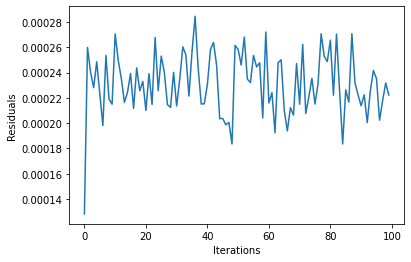

In [ ]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [21]:
lista = []
lista = result.state.residuals

In [23]:
 lista = [0.0001281945665608601,
 0.00025993396733031584,
 0.00024035982467323318,
 0.00022808109016064714,
 0.00024860289495729355,
 0.00022339511538588378,
 0.0001981703469245875,
 0.0002537001595362103,
 0.0002190380230882893,
 0.00021505449495147876,
 0.00027059952665616524,
 0.0002495625377794008,
 0.0002355096353987872,
 0.00021647691431256065,
 0.0002242063625686004,
 0.0002393294055842867,
 0.0002116979528318124,
 0.00024375997554106207,
 0.0002256859891956109,
 0.0002330296784652219,
 0.00021007336819962825,
 0.00023912762576736406,
 0.00021478265416324785,
 0.00026781275994493356,
 0.00022574442008949585,
 0.00025302289415492305,
 0.00024017997453056072,
 0.00021471894466498822,
 0.00021246019753196752,
 0.0002402312412538657,
 0.00021360754655137937,
 0.0002347263934314352,
 0.00026039544685785775,
 0.00025414559844609395,
 0.0002214426622442479,
 0.0002565084069194384,
 0.00028461068498442446,
 0.0002435626189164648,
 0.00021516912179358926,
 0.00021539264563917812,
 0.00023068556625838264,
 0.00025832198355418774,
 0.0002638604050482154,
 0.00024584210417981746,
 0.00020357277726693423,
 0.00020370657124817792,
 0.0001987132071841658,
 0.00020062265130070528,
 0.0001835559658410101,
 0.00026156032221931626,
 0.0002582928748501925,
 0.0002460259149170238,
 0.0002681884908397749,
 0.00023488225839986995,
 0.00023210146505792215,
 0.0002536397831831939,
 0.0002445039025918143,
 0.00024779504659547773,
 0.0002041829692478255,
 0.00027212911067220824,
 0.00021600696731285745,
 0.0002241304769353541,
 0.0001924621567972549,
 0.00024788044919681036,
 0.00025014330393949584,
 0.00021009122891046906,
 0.0001938355272000008,
 0.0002122296802168951,
 0.0002064219556544936,
 0.0002472189320584927,
 0.00021497513233640828,
 0.0002622452559355726,
 0.00020766617427327467,
 0.00022080981871845943,
 0.00023540734730240616,
 0.00021511467347528333,
 0.00023151933150705623,
 0.0002707650736637027,
 0.0002528415570402001,
 0.0002488037717852642,
 0.0002656642017425068,
 0.00022213944121032058,
 0.0002705328484668229,
 0.00022546922092611617,
 0.00018353924572093365,
 0.0002263770781461893,
 0.00021665358196651407,
 0.00027086877871263936,
 0.00023187921474512155,
 0.00022251179824684801,
 0.0002137584144395245,
 0.00022245412669234435,
 0.000200491605755469,
 0.0002255066239941417,
 0.00024171258369235798,
 0.0002352842664123873,
 0.0002023822775392723,
 0.00021782494661518756,
 0.0002318254624241514,
 0.00022229701847199373]

In [28]:
print(statistics.median(lista))

0.02311024488827194


In [15]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [17]:
result.state

In [18]:
result.state.residuals

[0.0001281945665608601,
 0.00025993396733031584,
 0.00024035982467323318,
 0.00022808109016064714,
 0.00024860289495729355,
 0.00022339511538588378,
 0.0001981703469245875,
 0.0002537001595362103,
 0.0002190380230882893,
 0.00021505449495147876,
 0.00027059952665616524,
 0.0002495625377794008,
 0.0002355096353987872,
 0.00021647691431256065,
 0.0002242063625686004,
 0.0002393294055842867,
 0.0002116979528318124,
 0.00024375997554106207,
 0.0002256859891956109,
 0.0002330296784652219,
 0.00021007336819962825,
 0.00023912762576736406,
 0.00021478265416324785,
 0.00026781275994493356,
 0.00022574442008949585,
 0.00025302289415492305,
 0.00024017997453056072,
 0.00021471894466498822,
 0.00021246019753196752,
 0.0002402312412538657,
 0.00021360754655137937,
 0.0002347263934314352,
 0.00026039544685785775,
 0.00025414559844609395,
 0.0002214426622442479,
 0.0002565084069194384,
 0.00028461068498442446,
 0.0002435626189164648,
 0.00021516912179358926,
 0.00021539264563917812,
 0.0002306855662